# Optimization Exercises

This notebook was written by Selin Ataç (selin.atac@epfl.ch) for the Optimization and Simulation course at EPFL (https://edu.epfl.ch/studyplan/en/doctoral_school/civil-and-environmental-engineering/coursebook/optimization-and-simulation-MATH-600). 

Please contact before distributing or reusing the material below.


## Table of Contents
* [Travelling Salesman Problem](#Travelling-Salesman-Problem)
    * [Problem definition and encoding](#Problem-definition)
    * [Implementation: The core functionality](#Implementation)
* [Optimization Algorithms](#Optimization-algorithms)
    * [Exercise 1: Full enumeration](#Exercise-1:-Full-enumeration)
    * [Exercise 2: Greedy algorithm](#Exercise-2:-Greedy-algorithm)
    * [Exercise 3: Local search](#Exercise-3:-Local-search)
    * [Exercise 4: Variable Neighborhood Search](#Exercise-4:-Variable-Neighborhood-Search)
    * [Exercise 5: Simulated annealing](#Exercise-5:-Simulated-annealing)
* [Testing the optimization algorithms and solution profiling](#Testing-the-optimization-algorithms-and-solution-profiling)
* [Multi-objective optimization](#Multi-objective-optimization)
* [(Priced) Knapsack Problem](#(Priced)-Knapsack-problem)
    * [Problem definition and encoding](#Problem-definition-(KP))
    * [Implementation](#Implementation-(KP))
    * [Pareto frontier](#View-the-Pareto-frontier)

## Travelling Salesman Problem

### Problem definition

- A salesman must visit $n$ cities.
- Every city must be visited exactly once.
- The salesman starts and ends the trip at his/her home city.
- The total trip length is assumed to be the cost of the travel.

### Objective

What sequence of cities minimizes the travel cost?

### Problem encoding

We consecutively number the cities: $0,..., n$

We encode the solutions as $x=(x_0, x_1,..., x_n, x_0)$ where

- $x_0$ is the index of the home city,
- $x_i$ is the index of the $i^{th}$ city visited along the way, and
- $x_n$ is the index of the last city visited before returning home.

### Implementation

#### The required python libraries
You will use the following python libraries in this exercise: `numpy`, `plotly`. Install it using `pip` on your command line:

    pip install numpy plotly

or if you are using conda:

    conda install numpy
    conda install -c plotly plotly

In [1]:
import numpy as np
import pandas as pd
from numpy import sqrt
import plotly
import plotly.graph_objects as go
import timeit
import itertools
import matplotlib.pyplot as plt
from numpy.random import Generator, PCG64
from plotly.subplots import make_subplots

### The core functionality

Before we optimize the path of the salesman, we need to construct several functions to help us simulate and display the path of the salesman.

Begin by implementing a function for simulating city locations on an x-y grid. 
At the end of this step, you will be able to generate a plot of cities on an x-y coordinate plot, path of the salesman, and a list of tuples representing the location of the cities.

1. Implement a function `simulate_cities(seed, n_cities)` which takes as input: 
  - `seed`: a numpy random seed value
  - `n_cities`: an integer for the number of cities to generate
  - The return of the function should be a dictionary of tuples, e.g., `{0: (x0,y0), 1: (x1,y1), ..., n: (xn,yn)}`

In [2]:
def simulate_cities(rg, n_cities):
    """Function to implement

    Args:
        rg (Generator object) : a numpy random seed value
        n_cities (int) : an integer for the number of cities to generate
        
    Returns:
        cities (dict): a dictionary of tuples
    
    Example:
        rg = Generator(PCG64(42069))
        simulate_cities(rg, 2)
        >>> {0: (2.4, 1.4), 1: (0.2, 3.5)}   
    """
    u = rg.uniform(size=(2, 10))
    cities = dict(list(enumerate(list(map(tuple, u.T)))))

    return cities

#### Test the function `simulate_cities(rg, n_cities)`

In [3]:
rg = Generator(PCG64(42069)) # set your own unique seed number
simulate_cities(rg, 10)

{0: (0.9478996465627648, 0.8072731499300757),
 1: (0.2974102502883651, 0.35227676836708866),
 2: (0.07180247229372805, 0.6985951690873387),
 3: (0.3295081953938601, 0.735711881881111),
 4: (0.5594414353429973, 0.7701562520511277),
 5: (0.8634674736423997, 0.7905928224207733),
 6: (0.721347982465723, 0.3989059418598707),
 7: (0.691424444294593, 0.34322732737709305),
 8: (0.5408533259842724, 0.5754637086577505),
 9: (0.4535449329926894, 0.6388855586960542)}

2. Implement a function `draw_salesman(path, cities)` which takes as input:
  - `path`: a list of integers which represents the sequence of cities visited, e.g. `[0,1,3,2,4,0]` 
  - `cities`: a dictionary of city x-y coordinates, keyed by the number of the city, use the return value of the `simulate_cities()` function as example: `{0: (x0,y0), 1: (x1,y1), ..., n: (xn,yn)}`.
  - The return of the function should display a visualization of the cities visited.

In [4]:
def draw_salesman(path, cities, title="Path taken"):
    """Function to implement

    Args:
        path (list): a row vector representing the solution to be evaluated
        cities (dict): data structure that contains supplementary 
            information about the problem, in particular the xy-coordinates of the 
            cities.
        **kwargs: arbitrary keyword arguments (optional variables)
    """

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_aspect('equal')
    ax.grid(ls=':')
    fig.tight_layout(pad=-1)
    X = []
    Y = []
    for city in path:
        x, y = cities.get(city)
        X.append(x)
        Y.append(y)
        plt.annotate(city, (x-1e-2, y + 2e-2))
        plt.scatter(x, y, c='k')
    plt.plot(X, Y, zorder=-1, label='path')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title(title)
    plt.legend()
    plt.show()

#### Test the function `draw_salesman(path, cities)`

{0: (0.9478996465627648, 0.8072731499300757), 1: (0.2974102502883651, 0.35227676836708866), 2: (0.07180247229372805, 0.6985951690873387), 3: (0.3295081953938601, 0.735711881881111), 4: (0.5594414353429973, 0.7701562520511277), 5: (0.8634674736423997, 0.7905928224207733), 6: (0.721347982465723, 0.3989059418598707), 7: (0.691424444294593, 0.34322732737709305), 8: (0.5408533259842724, 0.5754637086577505), 9: (0.4535449329926894, 0.6388855586960542)}


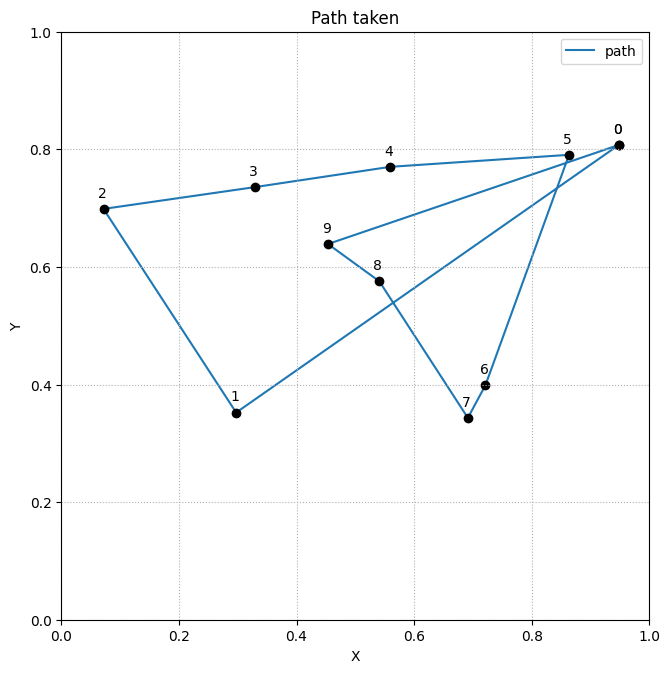

In [5]:
rg = Generator(PCG64(42069)) # set your own unique seed number
n_cities = 10
cities = simulate_cities(rg, n_cities) # simulate the list of cities
print(cities)
solution = list(range(0, n_cities)) # sample solution of the path of the salesman
solution.append(solution[0])
draw_salesman(solution, cities) # draw salesman

3. Implement a function `evaluate_city_sequence(path, cities)` which takes as input:
  - `path`: a list of integers which represents the sequence of cities visited, e.g. `[0,1,3,2,4,0]` 
  - `cities`: the dict of cities {n: (x, y)}
  - The return of the function should be the **total length of the travelled path**.
  
We use $c = \sqrt{a^2 + b^2}$ to calculate the distance between each city, including the distance from the final visited city back to the home city.

In [6]:
def evaluate_city_sequence(x, cities=None, **kwargs):
    """Function to implement

    Returns the objective function value of the solution x.

    Args:
        x (list): a row vector representing the solution to be evaluated
        cities (dict, optional): data structure that contains supplementary 
            information about the problem, in particular the xy-coordinates of the 
            cities.
        **kwargs: arbitrary keyword arguments (optional variables)
    
    Returns:
        Q (float): a scalar representing the objective function value of the total
            distance travelled
    
    Example:
        cities = {0: (2.4, 1.4), 1: (0.2, 3.5)}
        calculated = evaluate_city_sequence([0, 1], cities)
        print(calculated)
        >>> 3.041381
    """
    Q = 0
    for c, n in zip(x, x[1:]):
        xc, yc = cities.get(c)
        xn, yn = cities.get(n)
        dx = xn - xc
        dy = yn - yc
        Q += np.sqrt(dx**2 + dy**2)
    return Q

**Test the function `evaluate_city_sequence(x, cities=None, **kwargs)`** and verify that the calculation is correct.

In [7]:
def evaluate_city_sequence_test(cities={0: (0, 0), 1: (1, 1)}):
    """Very simple test
    
    Salesman starts at city zero with coordinates(0, 0), travels to city one with 
    coordinates(1, 1), and then returns to city zero.
    """

    # expected distance travelled
    expected = 2 * np.sqrt(2);
    
    # call your objective function
    calculated = evaluate_city_sequence([0, 1, 0], cities)
    
    # show your results
    results = print(
        'Expected={0:.3f}, Calculated={1:.3f}'.format(expected, calculated)
    )
    if abs(expected-calculated) < 1e-6:
        print('OK')
    else:
        print('NOT CORRECT')

evaluate_city_sequence_test()

Expected=2.828, Calculated=2.828
OK


---
***
___

## Optimization algorithms

### Simulate a traveling salesman

To test our optimizer, we need a function that simulates a path taken by a travelling salesman. 
Implement a function `generate_new_city_seq()` that generates a path sequence.
We assume that the salesman always starts and ends in city `0`.

A very simple example is a full (random) enumeration of the cities.

In [8]:
def generate_new_city_seq(rg, path, cities=None, **kwargs):
    """Function to implement

    Returns a permutation of the row vector "path", where the first element
    of "path" stays unchanged. Implement different specifications. For example:
    - exchanges two randomly selected entries of "path"

    Args:
        rg (Generator object) : a numpy random seed value
        path (list): a row vector representing the current city sequence
        cities (dict, optional): data structure that contains supplementary 
            information about the problem, in particular the coordinates of the 
            cities.
        **kwargs: arbitrary keyword arguments (optional variables)
    
    Returns:
        y (list): a row vector with a permutation of "path" 
        
        Where the first element of "y" is the first element of "path": y[0] == path[0]
    
    Example:
        city_seq = [0, 1, 2, 3, 4, 5]
        new_city_seq = generate_new_city_seq(city_seq)
        print(new_city_seq)
        >>> [0, 1, 3, 2, 4, 5]
    """
    new_path = path.copy()
    swap = rg.choice(path[1:-1], 2, replace=False)
    new_path[path.index(swap[0])] = swap[1]
    new_path[path.index(swap[1])] = swap[0]
    return new_path

#### Test the function

In [9]:
path = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,0]
print(path)
rg = Generator(PCG64(42070))
path = generate_new_city_seq(rg, path)
print(path)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0]
[0, 1, 2, 3, 6, 5, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0]


The code snippet above finds a random city that is not the first or last city, finds another random city and swap its location between the two.

#### Question 1:

Is this random city selection process equally distributed? i.e. is each city selected with equal probability?

#### Question 2:

How can we improve the solution search process? 

Try to answer these questions by using the following function:  `generate_new_city_seq_test()`

In [10]:
def generate_new_city_seq_test(rg, iterations):
    path = [0,1,2,3,4,5,6,7,8,9,0]
    n_cities = len(path)-1 
    data = np.zeros((n_cities, n_cities)) # we create a 10x10 matrix to calculate the sum of visits to each city
    for i in range(1, iterations):
        path = generate_new_city_seq(rg, path)
        for n in range(n_cities):
            data[n, path[n]] = data[n, path[n]] + 1 # increment by 1 for each sum in the sequence position
            
    fig = go.Figure()
    sequence = np.arange(n_cities)
    step = (sequence-n_cities/2.)/n_cities
    bar_width = 1./n
    
    for i in range(n_cities):
        city_name = "City " + str(i)
        fig.add_trace(go.Bar(x=sequence+step[i], y=data[i, :], width=bar_width, name=city_name))
    
    fig.update_xaxes(tickvals=sequence)
    fig.update_layout(title="Histogram: each shows the distribution of the cities in that position", template="presentation")
    fig.show()
    
#run the test
rg = Generator(PCG64(42069))
generate_new_city_seq_test(rg, iterations=10000)

What can you observe about the sequence permutation process?

### Algorithms

Notice in our sample solution, it was not ideal and the salesman's path criss-crossed. Our goal is to minimize the total distance travelled by the salesman, while visiting all the cities.

We can use the total path travelled as our **objective function**. Recall the function `evaluate_city_sequence()`, this is our objective function. In general, we will utilize two main functions: `generate_new_city_seq_XX()`, i.e., the new city sequence generator for XX algorithm, and `XX()`, i.e., the implementation of the XX optimization algorithm.

Now let us integrate `evaluate_city_sequence()` with the sequence generator `generate_new_city_seq_fe()` by implementing a **full enumeration** algorithm. This is a simple trial and error method.

---

### Exercise 1: Full enumeration

Functions to implement:

`generate_new_city_sequence_fe()`

`full_enumeration()`

Calculate the computational time and limitations of the full enumeration.

What is the maximum problem size (number of cities) that you could solve with this approach?

In [11]:
## FULL ENUMERATION
def generate_new_city_sequence_fe(x, cities=None, **kwargs):
    # implement your own solution here

    # returns a list of the new path
    return None


def full_enumeration(x, cities):
    fstar = np.inf
    xstar = None
    for t in itertools.permutations(x[1:-1]):
        tour = [0] + list(t) + [0]
        tl = evaluate_city_sequence(tour, cities)
        if tl < fstar:
            xstar = tour
            fstar = tl
    # returns the best solution and minimum distance travelled
    return xstar, fstar

best solution: [0, 6, 7, 1, 2, 3, 9, 8, 4, 5, 0]
distance travelled: 2.4496369525729875


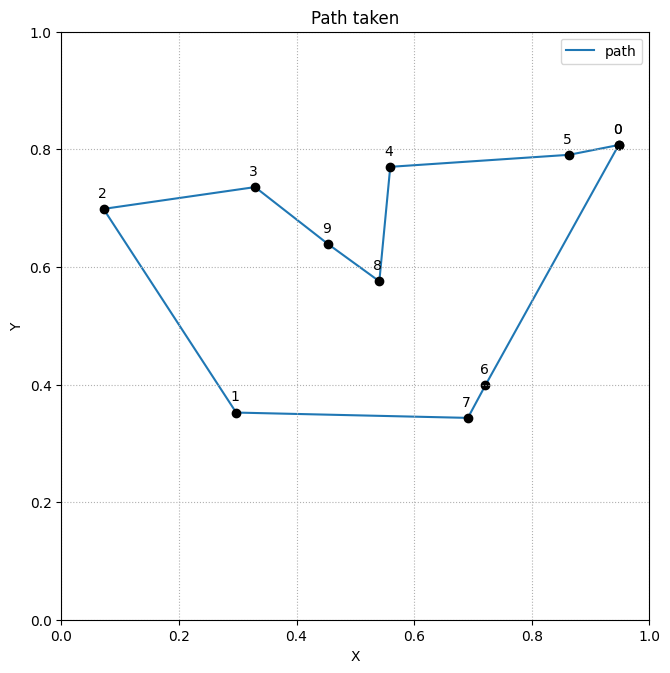

In [12]:
# Test
path = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0]
solution, distance = full_enumeration(path, cities)
print("best solution:", solution)
print("distance travelled:", distance)
draw_salesman(solution, cities)

***

### Exercise 2: Greedy algorithm

**Principles:**
- Each step is taken as decisions from the previous step, therefore depends on the previous step.
- It is easy to implement, but may generate poor solutions.

**The algorithm:**
1. Start from home city
2. Select the next closest city
3. Repeat 2 until all cities have been visited
4. Return to home city

**Discussion:** 

How would you implement this algorithm? If you can, implement it in your own Python notebook and test it out. Try to reuse portions of the code in the first exercise. 

(15 mins)

Functions to implement:

`generate_new_city_sequence_g()`

`greedy()`

Calculate the computational time.

Profile your greedy algorithm and compare it with the full enumeration algorithm. What do you observe? explain the pros and cons of each method.

In [13]:
## GREEDY
def generate_new_city_sequence_g(x, cities=None, **kwargs):
    # start your code here

    # end code
    return None


def greedy(x, cities):
    sequence = x.copy()[1:-1]
    # start from home city
    c = 0
    solution = [0]
    # repeat
    while True:
        dstar = np.inf
        # select the next closest city
        for n in sequence:
            dist = evaluate_city_sequence([c, n], cities)
            if dist < dstar:
                cstar = n
                dstar = dist
        c = cstar
        if len(sequence) > 0:
            sequence.remove(c)
            solution.append(c)
        else:
            # all cities have been visited
            break
    # return to home city
    solution.append(0)
    distance = evaluate_city_sequence(solution, cities)
    return solution, distance

best solution: [0, 5, 4, 9, 8, 6, 7, 1, 3, 2, 0]
distance travelled: 2.905119282080668


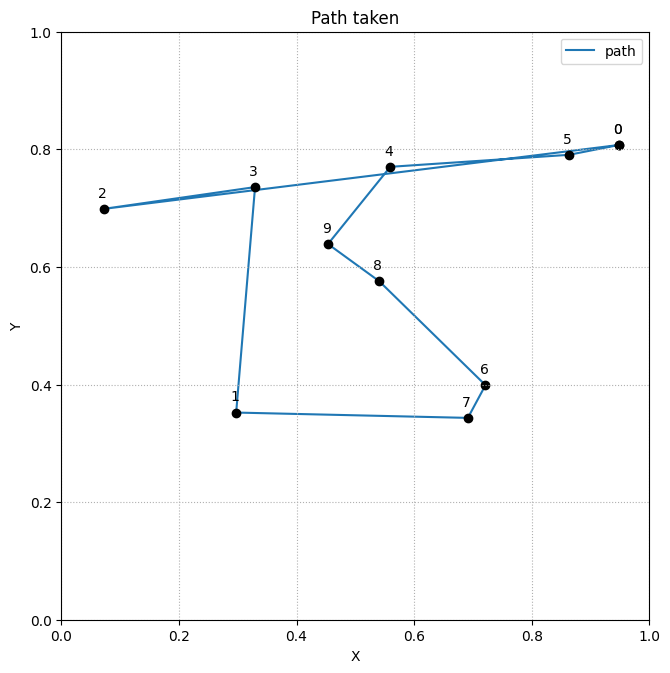

In [14]:
# Test
rg = Generator(PCG64(42069))  # set your own unique seed number
solution, distance = greedy(path, cities)
print("best solution:", solution)
print("distance travelled:", distance)
draw_salesman(solution, cities)

***

### Exercise 3: Local search

Functions to implement:

`generate_new_city_sequence_ls()`

`local_search()`

Calculate the computational time.

In [15]:
## LOCAL SEARCH
def generate_new_city_sequence_ls(x, cities=None, **kwargs):
    path = kwargs['path']
    rg = x
    new_path = path.copy()
    swap = rg.choice(path[1:-1], 2, replace=False)
    index_A = path.index(swap[0])
    index_B = path.index(swap[1])
    new_path[index_A] = swap[1]
    new_path[index_B] = swap[0]
    if index_A < index_B:
        new_path[index_A + 1:index_B] = path[index_A + 1:index_B][::-1]
    else:
        new_path[index_B + 1:index_A] = path[index_B + 1:index_A][::-1]
    return new_path


def local_search(x, cities, iterations=1000):
    tracker = []
    n_cities = len(cities)
    path = list(range(0, n_cities))
    path.append(0)
    distance_travelled = evaluate_city_sequence(path, cities)
    min_distance_travelled = distance_travelled
    best_solution = path
    print("running algorithm...")
    start_time = timeit.default_timer()
    for i in range(1, iterations):
        path = generate_new_city_sequence_ls(x, path=path)
        distance_travelled = evaluate_city_sequence(path, cities)
        if distance_travelled < min_distance_travelled:
            min_distance_travelled = distance_travelled
            best_solution = path
        tracker.append((i, min_distance_travelled, distance_travelled))
    print("algorithm end.")
    end_time = timeit.default_timer()
    print("time taken :{0:.5f}s".format(end_time - start_time))
    # display the tracker
    fig = go.Figure()
    x, y, y2 = zip(*tracker)
    fig.add_trace(go.Scatter(x=x, y=y, mode='lines', name='best value'))
    fig.add_trace(
        go.Scatter(x=x,
                   y=y2,
                   mode='lines',
                   line={'width': 0.5},
                   name='iteration value'))
    fig.update_layout(title='Best solution found',
                      template="presentation",
                      xaxis_title="Iteration",
                      yaxis_title="Distance")
    fig.show()
    return best_solution, min_distance_travelled

#### Test the function

running algorithm...
algorithm end.
time taken :0.06888s


best solution: [0, 6, 7, 8, 9, 3, 1, 2, 4, 5, 0]
distance travelled: 2.753990909688862


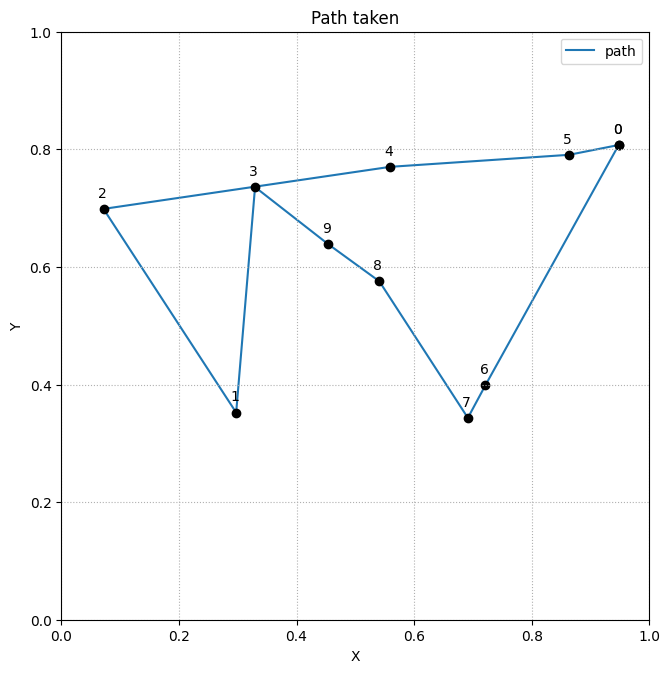

In [16]:
# Test
rg = Generator(PCG64(42069))  # set your own unique seed number
solution, distance = local_search(rg, cities, iterations=2000)
print("best solution:", solution)
print("distance travelled:", distance)
draw_salesman(solution, cities)

### Exercise 4: Variable Neighborhood Search

In variable neighbourhood search, we consider several neighbourhood structures.

When a local optimum has been found for a given neighborhood structure, continue with another structure.

**Input**: 

$V_1, V_2, ..., V_K$: Neighbourhood structures
where $K$ is the total number of neighborhoods

**Initialization**: 
- $x_c \leftarrow x_0$ (initial solution)
- $k\leftarrow 0$ 

Functions to implement:

`generate_new_city_sequence_vns_1()`

`generate_new_city_sequence_vns_2()`

`generate_new_city_sequence_vns_...()`

`generate_new_city_sequence_vns_k()`

`variable_neighborhood_search()`

Calculate the computational time.

In [17]:
## VARIABLE NEIGHBORHOOD SEARCH
def generate_new_city_sequence_vns_1(x, cities=None, **kwargs):
    path = kwargs['path']
    rg = x
    new_path = path.copy()
    swap = rg.choice(path[1:-1], 2, replace=False)
    index_A = path.index(swap[0])
    index_B = path.index(swap[1])
    new_path[index_A] = swap[1]
    new_path[index_B] = swap[0]
    if index_A < index_B:
        new_path[index_A + 1:index_B] = path[index_A + 1:index_B][::-1]
    else:
        new_path[index_B + 1:index_A] = path[index_B + 1:index_A][::-1]
    return new_path


def variable_neighborhood_search(x, cities, iterations=6000, K=50):
    tracker = []
    n_cities = len(cities)
    path = list(range(0, n_cities))
    path.append(0)
    distance_travelled = evaluate_city_sequence(path, cities)
    min_distance_travelled = distance_travelled
    print("running algorithm...")
    start_time = timeit.default_timer()
    k = 1
    flag = True
    for i in range(1, iterations):
        j = 1
        while j <= min(k, K):
            if flag:
                path = generate_new_city_sequence_vns_1(x, path=path)
            else:
                path = generate_new_city_seq(x, path=path)
            distance_travelled = evaluate_city_sequence(path, cities)
            if distance_travelled < min_distance_travelled:
                min_distance_travelled = distance_travelled
                best_solution = path
                break
            else:
                j += 1
        k += 1
        if k > K:
            k = 1
            flag = not flag
        tracker.append((i, min_distance_travelled, distance_travelled))
    print("algorithm end.")
    end_time = timeit.default_timer()
    print("time taken :{0:.5f}s".format(end_time - start_time))
    ### display the tracker
    fig = go.Figure()
    x, y, y2 = zip(*tracker)
    fig.add_trace(go.Scatter(x=x, y=y, mode='lines', name='best value'))
    fig.add_trace(
        go.Scatter(x=x,
                   y=y2,
                   mode='lines',
                   line={'width': 0.5},
                   name='iteration value'))
    fig.update_layout(title='Best solution found',
                      template="presentation",
                      xaxis_title="Iteration",
                      yaxis_title="Distance")
    fig.show()
    return best_solution, min_distance_travelled

#### Test the function

running algorithm...
algorithm end.
time taken :0.32954s


best solution: [0, 6, 7, 1, 2, 3, 9, 8, 4, 5, 0]
distance travelled: 2.4496369525729875


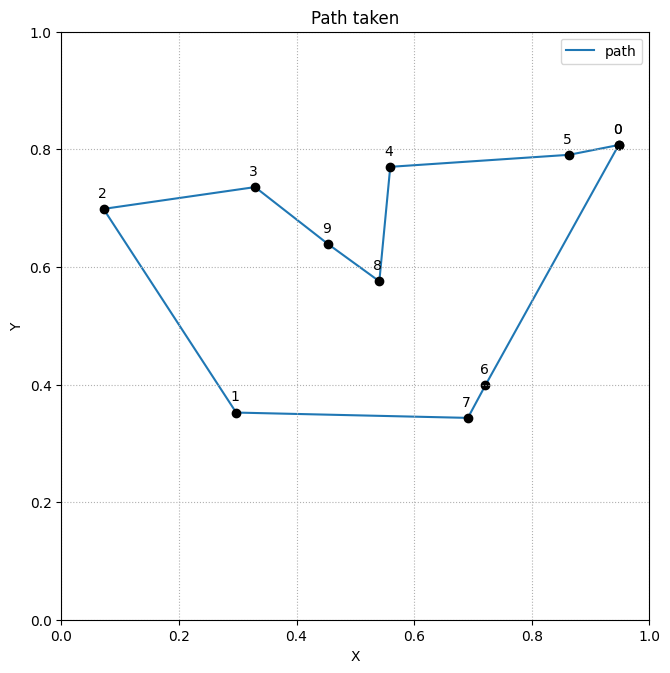

In [18]:
# Test
rg = Generator(PCG64(42069))
solution, distance = variable_neighborhood_search(rg, cities, iterations=2000, K=9) # new input parameter K
print("best solution:", solution)
print("distance travelled:", distance)
draw_salesman(solution, cities)

### Exercise 5: Simulated annealing

In simulated annealing, we consider solutions that are not better from the current best solution with a probability.

***
- Select a random solution $y \in V(x_k)$
- If $f(y) \leq f(x_k)$ 
    - $x_{k+1} = y$
- Else 
    - $x_{k+1} = y$ with probability $e^{-\frac{f(y)-f(x_k)}{T}}$ with T > 0
***

To deal with that, one can draw $r$ from $uniform(0,1)$ distribution and accept $y$ if $e^{-\frac{f(y)-f(x_k)}{T}} > r$.

Functions to implement:

`generate_new_city_sequence_sa()`

`simulated_annealing()`

Calculate the computational time.

In [19]:
## SIMULATED ANNEALING
def generate_new_city_sequence_sa(x, cities=None, **kwargs):
    # start your code here

    # returns the new path
    # end code
    return None


def temperature(init, i, updates):
    p0 = 1 - 1e-2
    pf = 1e-6
    T = (np.log(p0) * init) / (np.log(p0 + ((pf - p0) / updates) * i))
    return T


def simulated_annealing(x, cities, M=100, K=20, t_init=0.1):
    tracker = []
    path = list(range(0, n_cities))
    path.append(0)
    distance_travelled = evaluate_city_sequence(path, cities)
    min_distance_travelled = distance_travelled
    T_list = []
    print("running algorithm...")
    start_time = timeit.default_timer()
    i = 0
    for m in range(M):
        T = temperature(t_init, m, M)
        for k in range(K):
            i += 1
            new_path = generate_new_city_sequence_ls(x, path=path)
            distance_travelled = evaluate_city_sequence(new_path, cities)
            T_list.append(T)
            delta = distance_travelled - min_distance_travelled
            if delta < 0:
                min_distance_travelled = distance_travelled
                best_solution = new_path
            else:
                r = rg.uniform()
                if r < np.exp(-delta / T):
                    path = new_path
            tracker.append((i, min_distance_travelled, distance_travelled, T))
    print("algorithm end.")
    end_time = timeit.default_timer()
    print("time taken :{0:.5f}s".format(end_time - start_time))
    # display the tracker
    x, y, y2, y3 = zip(*tracker)
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(go.Scatter(x=x, y=y, mode='lines', name='best value'))
    fig.add_trace(
        go.Scatter(x=x,
                   y=y2,
                   mode='lines',
                   line={'width': 0.5},
                   name='iteration value'))
    fig.add_trace(go.Scatter(x=x, y=y3, mode='lines', name='temperature'),
                  secondary_y=True)
    fig.update_layout(title='Best solution found',
                      template="presentation",
                      xaxis_title="Iteration",
                      yaxis_title="Distance")
    fig.show()
    return best_solution, min_distance_travelled

#### Test the function

running algorithm...
algorithm end.
time taken :0.01899s


best solution: [0, 6, 7, 1, 2, 3, 9, 8, 4, 5, 0]
distance travelled: 2.4496369525729875


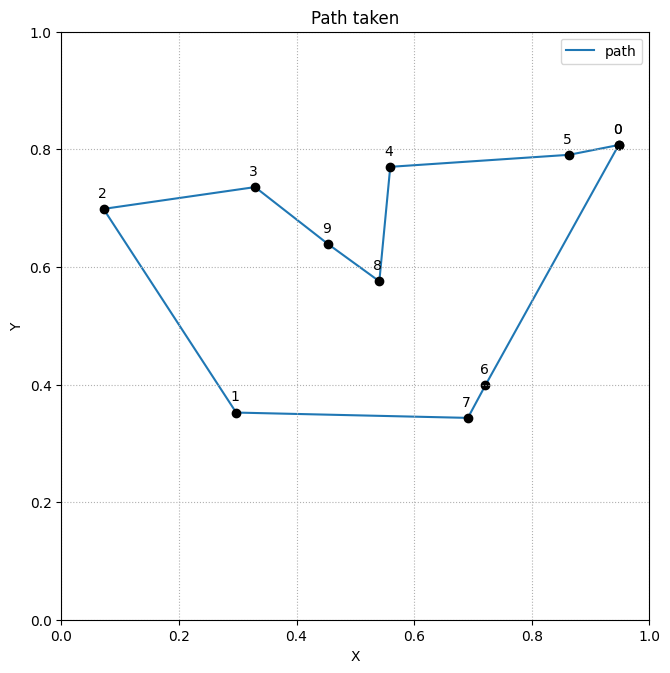

In [20]:
# Test
rg = Generator(PCG64(42069))
solution, distance = simulated_annealing(rg, cities, M=100, K=2, t_init=3)
print("best solution:", solution)
print("distance travelled:", distance)
draw_salesman(solution, cities)

---
***
___

## Testing the optimization algorithms and solution profiling

### Testing
#### Test your optimization functions using `optimization_TSP_test()`

In [21]:
# Run the optimization by reusing the functions simulateCities(), drawSalesman(), evaluate()

def optimization_TSP_test(rg, iterations=5000):
    cities = simulate_cities(rg, n_cities)
    inital_solution = list(range(len(cities))) + [0]
    print(cities)
    print("initial solution:", inital_solution)
    print("inital distance travelled:", evaluate_city_sequence(inital_solution, cities))
    draw_salesman(inital_solution, cities, "Initial Solution") # show the inital solution
    
    # Full enumeration section 
    print("Full Enumeration\n-----------")
    fe_solution, fe_distance = full_enumeration(inital_solution, cities)
    print("best solution:", solution)
    print("distance travelled:", fe_distance)
    draw_salesman(fe_solution, cities, "Full enumeration")
    
    # Greedy algorithm section
    # Implement your greedy algorithm here
    # ...
    # ...
    # draw_salesman(solution, cities)
    
    # Local search
    # Implement your local search algorithm here
    
    # Simulated annealing
    # Implement your simulated annealing here
    
    # VNS
    # Implement your VNS here

# run all
#rg = Generator(PCG64(42069)) 
#optimization_TSP_test(rg, iterations=100000)

---

### Solution profiling
We want to be able to track the performance of the algorithm. We can do so by monitoring the minimum distance over iterations. We can modify the code by adding a tracker that keeps track of the iteration number, minimum travelled distance so far, and the distance travelled at that iteration.

In [22]:
def full_enumeration_(rg, cities, iterations):
    tracker = [] # a list of tuple to track the min distance
    path = list(range(len(cities))) + [0]
    distance_travelled = evaluate_city_sequence(path, cities) # calculate the inital objective function
    
    min_distance_travelled = distance_travelled # save the current solution as the "best solution"
    best_solution = path                        # save the current solution as the "best solution"
    
    print("running algorithm...")
    start_time = timeit.default_timer() # implement a timer to track running time
    for i in range(1, iterations):
        path = generate_new_city_seq(rg, path)
        distance_travelled = evaluate_city_sequence(path, cities)
        if distance_travelled < min_distance_travelled:
            min_distance_travelled = distance_travelled # update the best solution if the distance is shorter
            best_solution = path
        tracker.append((i, min_distance_travelled, distance_travelled))
    print("algorithm end.")
    end_time = timeit.default_timer()
    print("time taken :{0:.5f}s".format(end_time - start_time))
    best_solution.append(best_solution[0])
    
    # display the tracker
    fig = go.Figure()
    x, y, y2 = zip(*tracker)
    fig.add_trace(go.Scatter(x=x, y=y, mode='lines', name='best value'))
    fig.add_trace(go.Scatter(x=x, y=y2, mode='lines', line={'width': 0.5}, name='iteration value'))
    fig.update_layout(
        title='Best solution found', template="presentation", xaxis_title="Iteration", yaxis_title="Distance")
    fig.show()
    
    return best_solution, min_distance_travelled

## run
#rg = Generator(PCG64(42069)) 
#n_cities = 10
#cities = simulate_cities(rg, n_cities)
#solution, distance = full_enumeration_(rg, cities, iterations=100000)
#print("best solution:", solution)
#print("distance travelled:", distance)
#
#draw_salesman(solution, cities)

---
***
___

# Multi-objective optimization

In this lab, we will implement a multi-objective optimization algorithm (described in the lecture notes). We will use one of the algorithms developed in the previous lab on TSP, e.g.,
- simulated annealing, or
- variable neighbourhood search, or
- local search.

## Concepts in multi-objective optimization

- We need to minimize several objective functions.
- In many practical applications, the objectives are conflicting.
- Improving one objective may deteriorate several others (e.g. risk vs reward).

$$
min F(x) = (f_1(x), ..., f_p(x))
$$
subject to
$$
x \in F \subseteq \mathbb{R}^n
$$
where
$$
F: \mathbb{R}^n \rightarrow \mathbb{R}^p
$$

## Dominance

Notation:

$x_1$ dominates $x_2$: $F(x_1)\prec F(x_2)$

Dominance must fulfil 2 conditions, assuming we want to **minimize**

1. $x_1$ is no worse than $x_2$ in **any** objective: $\forall i \in \{1,...,p\},f_i(x_1)\leq f_i(x_2)$
2. $x_1$ is strictly better in at least one objective: $\exists i \in \{1,...,p\}, f_i(x_1)<f_i(x_2)$

## Methods in multi-objective optimization

Several methods are possible:

1. Weighted sum
2. Lexicographic rules (e.g. sequence by importance)
3. Constrained optimization
4. **Local search**/**heuristics**

### Pseudo algorithm for local search

(see lecture 8 notes, page 23)

Main difference with single objective optimization is that we need to maintain a set $P$ of potential Pareto optimal solutions such that 
$$ \forall x,y \in P, F(x) \nprec F(y)$$ and $$F(y) \nprec F(x). $$

**Initialization:**

Set with a first set of $P$ solutions (can be just one solution in $P$)

**Main iteration:**

1. Select a random solution $x$ from $P$, define $x^+$ as a neighbour solution  
2. Define 2 sets: $D(x^+)$ and $S(x^+)$, where

$$D(x^+)=\{y\in P, s.t. F(x^+)\prec F(y)\}$$

$$S(x^+)=\{y\in P, s.t. F(y)\prec F(x^+)\}$$

In other words, at each iteration, compare each objective function of the new solution $x^+$ against all $y$ in $P$. If condition is fulfiled for any of the above, put $y$ into the respective set.

3. If $S(x^+)=\emptyset$
    
    Update $P$ (remove all exisiting solutions in the Pareto set, $P$, if it appears in $D$ and add the new solution to $P$):
$$
P^+ = P\cup \{x^+\} \setminus D(x^+)
$$

---
***
___

## (Priced) Knapsack problem

### Problem definition (KP)

Each item has a weight $w$, utility $u$ and cost $c$. What is the set of items that can be put in the knapsack that is below the maximum weight and minimizes the cost and maximizes the utility?

### Problem encoding

We define our decision variable as $x_i=1$ if item $i$ is in knapsack, $0$ otherwise.

### Objectives

1. Maximizing the utility: $\max \mathcal{f}(x)=\sum_{i=1}^n u_i x_i$ 
2. Minimizing the cost: $\min \mathcal{f}(x)=\sum_{i=1}^n c_i x_i$
3. $w^Tx \leq W$ where $W$ is the maximum weight allowed, e.g. 100kg

We start by generating a series of random numbers for our test, item weight, utility and cost respectively:

In [23]:
#My example

rg = Generator(PCG64(42069)) # set your own unique seed number

item_weights = rg.integers(10, 50, 20)
item_utility = rg.integers(0, 100, 20)
item_cost = rg.random(20)

print("weights:", item_weights)
print("utility:", item_utility)
print("cost:", item_cost)

weights: [45 47 29 21 20 12 49 23 43 32 28 44 39 38 46 37 11 31 28 28]
utility: [88 80 27 35 37 69 95 73 36 77 74 79 46 39 17 34 71 57 48 63]
cost: [0.69272757 0.57418302 0.98927909 0.85750327 0.85636257 0.15411544
 0.82684282 0.01250091 0.58646462 0.67306592 0.24567093 0.76947212
 0.09844735 0.70031685 0.70773743 0.41338569 0.23973496 0.4679362
 0.06035837 0.88427089]


In [24]:
#Michel's example

item_weights = np.array([84, 27, 47, 22, 21, 96, 42, 46, 54, 53, 32, 78])
item_utility = np.array([80, 31, 48, 17, 27, 84, 34, 39, 46, 58, 23, 67])
item_cost = np.array([0.50328447, 0.41431774, 0.07765353, 0.75842330, 
             0.14050556, 0.72089439, 0.11669739, 0.56723896, 
             0.02430532, 0.01255171, 0.03059062, 0.17285314])

print("weights:", item_weights)
print("utility:", item_utility)
print("cost:", item_cost)

weights: [84 27 47 22 21 96 42 46 54 53 32 78]
utility: [80 31 48 17 27 84 34 39 46 58 23 67]
cost: [0.50328447 0.41431774 0.07765353 0.7584233  0.14050556 0.72089439
 0.11669739 0.56723896 0.02430532 0.01255171 0.03059062 0.17285314]


### Implementation (KP)

Next, we implement the objective functions `total_cost()` and `total_utility()` and the functions that will impose the weight constraint, i.e., `weight_limit()` and `weight()`:

In [25]:
# objective functions
# inputs are a list of indices
def total_cost(solution):
    # return the total cost of the items in the knapsack
    cost = np.inner(solution, item_cost)
    return cost


def total_utility(solution):
    # return the total utility of the items in the knapsack
    utility = np.inner(solution, item_utility)
    return utility


# constraint on weight
def weight_limit(solution, max_weight):
    # return True if the total weight is below max_weight
    if total_weight(solution) <= max_weight:
        return True
    else:
        return False


def total_weight(solution):
    # return the total weight of the items in the knapsack
    weight = np.inner(solution, item_weights)
    return weight

Implement the dominance condition and the main iteration Pareto conditions by `improvement()` and `dominance()` functions.

In [26]:
# Pareto dominance
def improvement(x, y):
    # return true if x dominates y
    if (x['utility'] > y['utility']) & (x['cost'] < y['cost']):
        return True
    else:
        return False
    
def dominance(P, x):
    # return the sets D and S with respect to x
    D = []
    S = []
    for y in P:
        if improvement(x, y):
            D.append(y)
        elif improvement(y, x):
            S.append(y)
    return D, S

In [27]:
def knapsack(rg, solution, W):
    # return the new solution
    new_solution = solution.copy()
    pick = rg.choice(items, 1)
    new_solution[pick] = 1 - new_solution[pick]
    if total_weight(new_solution) > W:
        while True:
            pick = rg.choice(items, 1)
            new_solution[pick] = 1 - new_solution[pick] 
            if total_weight(new_solution) <= W:
                break
    return new_solution

In [28]:
# test knapsack generation
rg = Generator(PCG64(42060))
iterations = int(1e4)
W = 300
n = len(item_cost)
solutions = []
items = np.arange(0,n)
solution = np.zeros(n)
totals = solution
for i in range(iterations):
    solution = np.array(solution)
    solution = tuple(knapsack(rg, solution, W))
    if solution in solutions:
        continue
    solutions.append(solution)
    totals += np.array(solution)

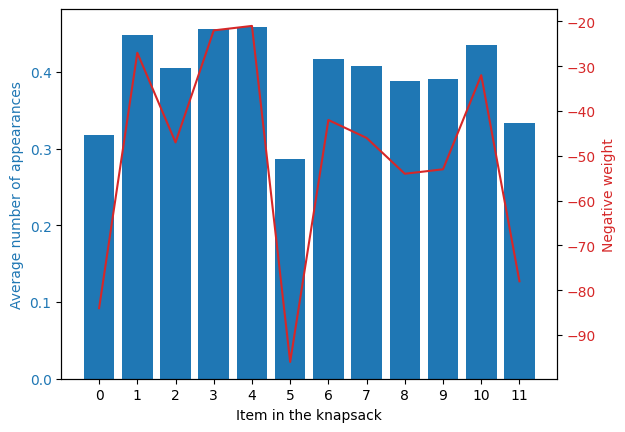

In [29]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('Item in the knapsack')
ax1.set_ylabel('Average number of appearances', color='tab:blue')
ax1.bar(items, totals / len(solutions))
ax1.set_xticks(items)
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax2 = ax1.twinx()
ax2.set_ylabel('Negative weight', color='tab:red')
ax2.plot(-item_weights, c='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
plt.show()

### Main loop

***
1. Initialize empty lists, the pareto set, considered set, and removed set, to store solutions and costs.
2. Generate an initial random solution and add it to P. For example, start with a random item from the set.
3. Add to $P$, the solution, cost, and the total weight, as a dictionary of values.

Main iteration

a. Select a random solution set from set $P$ \
b. Implement your optimization algorithm \
c. Compute the new cost of the new solution \
d. Compute the Pareto dominance, i.e., sets $D$ and $S$ \
e.\
If $S(x^+)=\emptyset$  \
    - add items $p$ in $P$ to list $R$ for all items in $D$ and not already in $R$ \
    - remove items in $P$ \
    - add new_solution to $P$ \
   Else \
    - track considered solutions
        
4. Return the pareto set, considered set and removed set
***
        

## Full enumeration

In [30]:
W = 300
P = []
Q = []
R = []
n = len(item_cost)
u = []
c = []
w = []
totals = np.zeros(n)
for solution in itertools.product([0, 1], repeat=n):
    weight = total_weight(solution)
    if weight <= W:
        totals += solution
        utility = total_utility(solution)
        cost = total_cost(solution)
        x = {
            'solution': solution,
            'utility': utility,
            'cost': cost,
            'weight': weight
        }
        if len(P) < 1:
            P.append(x)
        else:
            D, S = dominance(P, x)
            if len(S) == 0:
                P.append(x)
                for y in D:
                    P.remove(y)
                    if y not in R:
                        R.append(y)
            else:
                Q.append(x)
        u.append(utility)
        c.append(cost)
        w.append(weight)

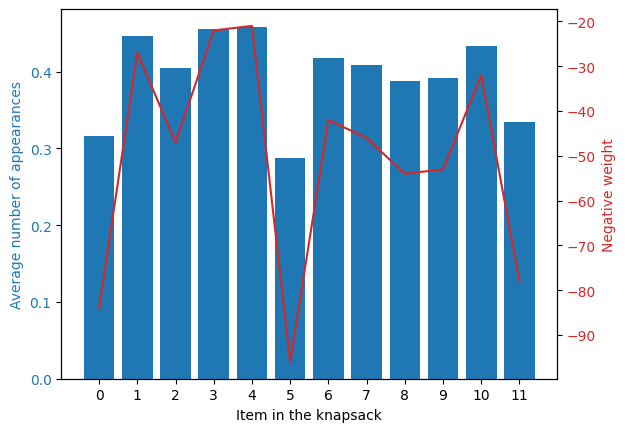

In [31]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('Item in the knapsack')
ax1.set_ylabel('Average number of appearances', color='tab:blue')
ax1.bar(items, totals/len(w))
ax1.set_xticks(items)
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax2 = ax1.twinx()
ax2.set_ylabel('Negative weight', color='tab:red')
ax2.plot(-item_weights, c='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
plt.show()

In [32]:
Xs, Ys = u, c
sorted_list = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=True)
pareto_front = [sorted_list[0]]
for pair in sorted_list[1:]:
    if pair[1] < pareto_front[-1][1]:
        pareto_front.append(pair)
pf_X = [pair[0] for pair in pareto_front]
pf_Y = [pair[1] for pair in pareto_front]

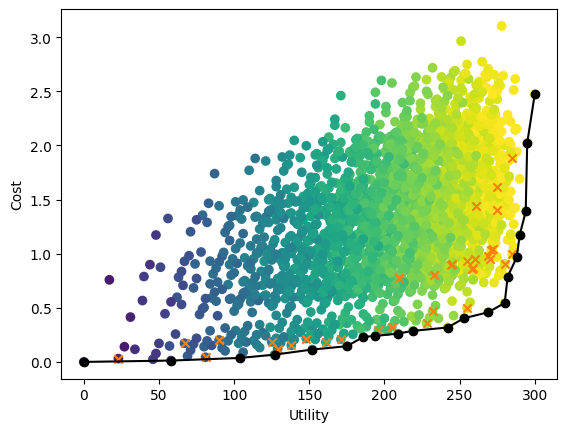

In [33]:
P = pd.DataFrame(P)
Q = pd.DataFrame(Q)
R = pd.DataFrame(R)
_ = plt.scatter(u, c, c=w, zorder=-1)
_ = plt.scatter(P['utility'], P['cost'], c='k')
_ = plt.scatter(R['utility'], R['cost'], marker='x', c='tab:orange', zorder=0)
_ = plt.plot(pf_X, pf_Y, '-', c='k', zorder=1)
plt.xlabel('Utility')
plt.ylabel('Cost')
plt.show()

## Local search

In [34]:
W = 300
P = []
Q = []
R = []
n = len(item_cost)
u = []
c = []
w = []
rg = Generator(PCG64(42060))
iterations = int(1e3)
W = 300
n = len(item_cost)
items = np.arange(0, n)
new_solution = np.zeros(n)
solutions = []
for i in range(iterations):
    solution = np.array(new_solution)
    new_solution = tuple(knapsack(rg, solution, W))
    if new_solution in solutions:
        continue
    solutions.append(new_solution)
    weight = total_weight(new_solution)
    utility = total_utility(new_solution)
    cost = total_cost(new_solution)
    x = {
        'solution': new_solution,
        'utility': utility,
        'cost': cost,
        'weight': weight
    }
    if len(P) < 1:
        P.append(x)
    else:
        D, S = dominance(P, x)
        if len(S) == 0:
            P.append(x)
            for y in D:
                P.remove(y)
                if y not in R:
                    R.append(y)
        else:
            Q.append(x)
        u.append(utility)
        c.append(cost)
        w.append(weight)

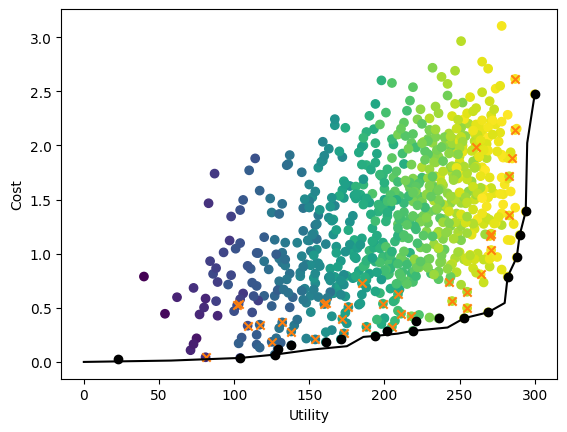

In [35]:
P = pd.DataFrame(P)
Q = pd.DataFrame(Q)
R = pd.DataFrame(R)
_ = plt.scatter(u, c, c=w, zorder=-1)
_ = plt.scatter(P['utility'], P['cost'], c='k')
_ = plt.scatter(R['utility'], R['cost'], marker='x', c='tab:orange', zorder=0)
_ = plt.plot(pf_X, pf_Y, '-', c='k', zorder=1)
plt.xlabel('Utility')
plt.ylabel('Cost')
plt.show()

## Simulated annealing

In [36]:
W = 300
P = []
Q = []
R = []
S = []
n = len(item_cost)
u = []
c = []
w = []
rg = Generator(PCG64(42060))
iterations = int(1e3)
W = 300
n = len(item_cost)
items = np.arange(0, n)
new_solution = np.zeros(n)
solutions = []
t_init = 250
solution = np.array(new_solution)
T_l = []
for i in range(iterations):
    T = temperature(t_init, i, iterations)
    T_l.append(T)
    new_solution = tuple(knapsack(rg, solution, W))
    if new_solution in solutions:
        continue
    weight = total_weight(solution)
    utility = total_utility(solution)
    cost = total_cost(solution)
    new_weight = total_weight(new_solution)
    new_utility = total_utility(new_solution)
    new_cost = total_cost(new_solution)
    x = {
        'solution': solution,
        'utility': utility,
        'cost': cost,
        'weight': weight
    }
    y = {
        'solution': new_solution,
        'utility': new_utility,
        'cost': new_cost,
        'weight': new_weight
    }
    r = rg.uniform()
    q = .5 #rg.uniform()
    delta = q * (total_utility(solution) - total_utility(new_solution)) + (
        1 - q) * (total_cost(new_solution) - total_cost(solution))
    if len(P) < 1:
        P.append(y)
    else:
        D, S = dominance(P, y)
        if (len(S) == 0):
            solution = np.array(new_solution)
            solutions.append(tuple(solution))
            P.append(y)
            for z in D:
                P.remove(z)
                if z not in R:
                    R.append(z)
        elif r > np.exp(delta / T):
            solution = np.array(new_solution)
            solutions.append(tuple(solution))
        else:
            Q.append(y)
        u.append(new_utility)
        c.append(new_cost)
        w.append(new_weight)

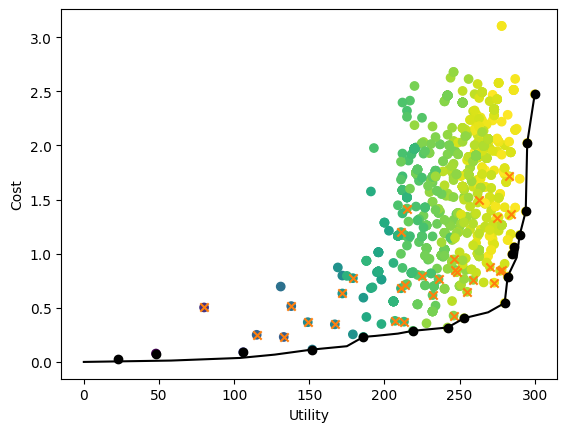

In [37]:
P = pd.DataFrame(P)
Q = pd.DataFrame(Q)
R = pd.DataFrame(R)
_ = plt.scatter(u, c, c=w, zorder=-1)
_ = plt.scatter(P['utility'], P['cost'], c='k')
_ = plt.scatter(R['utility'], R['cost'], marker='x', c='tab:orange', zorder=0)
_ = plt.plot(pf_X, pf_Y, '-', c='k', zorder=1)
plt.xlabel('Utility')
plt.ylabel('Cost')
plt.show()

### Run the optimization

In [38]:
#rg = Generator(PCG64(42069)) # set your own unique seed number
#P, Q, R = main(rg, iterations=1000, W=300) # weight limit=W

### View the Pareto frontier

In [39]:
fig = go.Figure()

c = pd.DataFrame(P).set_index('utility')
x, y = list(zip(*c['cost'].items()))
fig.add_trace(go.Scatter(x=x, y=y, mode='markers+text', name='pareto', 
    hovertemplate ='items: [%{hovertext}]', hovertext=c['solution'],
    text=c['weight'], texttemplate = "%{text} kg", textposition="bottom center", textfont = {'size': 12}))

c = pd.DataFrame(R).set_index('utility')
x, y = list(zip(*c['cost'].items()))
fig.add_trace(go.Scatter(x=x, y=y, mode='markers', marker_symbol='x', name='removed',
    hovertemplate ='items: [%{hovertext}]', hovertext=c['solution'],))

c = pd.DataFrame(Q).set_index('utility')
x, y = list(zip(*c['cost'].items()))
fig.add_trace(go.Scatter(x=x, y=y, mode='markers',name='considered',
    hovertemplate ='items: [%{hovertext}]', hovertext=c['solution'], opacity=.2),)

fig.update_layout(template="presentation", xaxis_title="Utility", yaxis_title="Cost", width=800, height=600)
fig.show()

## Further exercises

Try to apply a **constrained optimization** method on the knapsack problem

1. Choose one objective function to minimize
2. Apply a constraint on the other objective function(s)

For example, constraint on *max weight* and *min utility*, and optimize (single objective) on *min cost*.